In [6]:
#hide
from utils import *

# A fastai Learner from Scratch

## Data

In [7]:
path = untar_data(URLs.IMAGENETTE_160)

In [8]:
t = get_image_files(path)
t[0]

Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

In [9]:
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

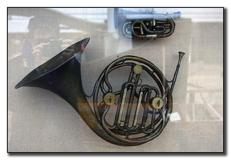

In [10]:
im = Image.open(files[0])
im

In [11]:
im_t = tensor(im)
im_t.shape

torch.Size([160, 231, 3])

In [12]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03394916','n03417042','n03445777','n02102040','n03425413','n03888257','n03028079','n03000684','n01440764','n02979186']

In [13]:
v2i = lbls.val2idx(); v2i

{'n03394916': 0,
 'n03417042': 1,
 'n03445777': 2,
 'n02102040': 3,
 'n03425413': 4,
 'n03888257': 5,
 'n03028079': 6,
 'n03000684': 7,
 'n01440764': 8,
 'n02979186': 9}

### Dataset

In [14]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

In [15]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [16]:
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[0]
x.shape,y

(torch.Size([64, 64, 3]), tensor(0))

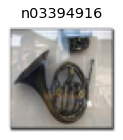

In [18]:
show_image(x, title=lbls[y]);

In [19]:
def collate(idxs, ds): 
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

In [20]:
x,y = collate([1,2], train_ds)
x.shape,y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [21]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

In [22]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4544, 0.4453, 0.4141]), tensor([0.2812, 0.2766, 0.2981])]

In [ ]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

In [ ]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0,3,1,2))

In [ ]:
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([0.3732, 0.4907, 0.5633]), tensor([1.0212, 1.0311, 1.0131]))

## Module and Parameter

In [ ]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

In [ ]:
Parameter(tensor(3.))

tensor(3., requires_grad=True)

In [ ]:
class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

In [ ]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

In [ ]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [ ]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

torch.Size([128, 4, 64, 64])

In [ ]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x): return x@self.w.t() + self.b

In [ ]:
l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

torch.Size([3, 2])

In [ ]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)

In [ ]:
t = T()
len(t.parameters())

4

In [ ]:
t.cuda()
t.l.w.device

device(type='cuda', index=5)

### Simple CNN

In [ ]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

In [ ]:
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [ ]:
m = simple_cnn()
len(m.parameters())

10

In [ ]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.5239089727401733 0.8776043057441711
0.43470510840415955 0.8347987532615662
0.4357188045978546 0.7621666193008423
0.46562111377716064 0.7416611313819885


torch.Size([128, 10])

## Loss

In [ ]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

In [ ]:
loss = nll(sm, yb)
loss

tensor(2.5666, grad_fn=<NegBackward>)

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

In [ ]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(3.9784, grad_fn=<SelectBackward>)

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [ ]:
sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

In [ ]:
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

## Learner

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr(self, 'params,lr,wd')
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr(self, 'model,dls,loss_func,lr,cbs,opt_func')
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')
    
    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

### Callbacks

In [ ]:
class Callback(GetAttr): _default='learner'

In [ ]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In [ ]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [ ]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1275552130636814 0.2314922378287042


0 False 1.9942575636942674 0.2991082802547771


### Scheduling the Learning Rate

In [ ]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [ ]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.6336045582954903 0.11014890695955222


0 False 2.230653363853503 0.18318471337579617


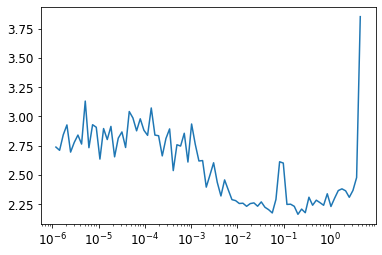

In [ ]:
plt.plot(lrfind.lrs[:-2],lrfind.losses[:-2])
plt.xscale('log')

In [ ]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In [ ]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [ ]:
learn.fit(8)

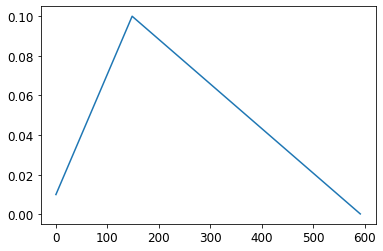

In [ ]:
plt.plot(onecyc.lrs);

## Conclusion

## Questionnaire

> tip: Experiments: For the questions here that ask you to explain what some function or class is, you should also complete your own code experiments.

1. What is `glob`?
1. How do you open an image with the Python imaging library?
1. What does `L.map` do?
1. What does `Self` do?
1. What is `L.val2idx`?
1. What methods do you need to implement to create your own `Dataset`?
1. Why do we call `convert` when we open an image from Imagenette?
1. What does `~` do? How is it useful for splitting training and validation sets?
1. Does `~` work with the `L` or `Tensor` classes? What about NumPy arrays, Python lists, or pandas DataFrames?
1. What is `ProcessPoolExecutor`?
1. How does `L.range(self.ds)` work?
1. What is `__iter__`?
1. What is `first`?
1. What is `permute`? Why is it needed?
1. What is a recursive function? How does it help us define the `parameters` method?
1. Write a recursive function that returns the first 20 items of the Fibonacci sequence.
1. What is `super`?
1. Why do subclasses of `Module` need to override `forward` instead of defining `__call__`?
1. In `ConvLayer`, why does `init` depend on `act`?
1. Why does `Sequential` need to call `register_modules`?
1. Write a hook that prints the shape of every layer's activations.
1. What is "LogSumExp"?
1. Why is `log_softmax` useful?
1. What is `GetAttr`? How is it helpful for callbacks?
1. Reimplement one of the callbacks in this chapter without inheriting from `Callback` or `GetAttr`.
1. What does `Learner.__call__` do?
1. What is `getattr`? (Note the case difference to `GetAttr`!)
1. Why is there a `try` block in `fit`?
1. Why do we check for `model.training` in `one_batch`?
1. What is `store_attr`?
1. What is the purpose of `TrackResults.before_epoch`?
1. What does `model.cuda` do? How does it work?
1. Why do we need to check `model.training` in `LRFinder` and `OneCycle`?
1. Use cosine annealing in `OneCycle`.

### Further Research

1. Write `resnet18` from scratch (refer to <<chapter_resnet>> as needed), and train it with the `Learner` in this chapter.
1. Implement a batchnorm layer from scratch and use it in your `resnet18`.
1. Write a Mixup callback for use in this chapter.
1. Add momentum to SGD.
1. Pick a few features that you're interested in from fastai (or any other library) and implement them in this chapter.
1. Pick a research paper that's not yet implemented in fastai or PyTorch and implement it in this chapter.
  - Port it over to fastai.
  - Submit a pull request to fastai, or create your own extension module and release it. 
  - Hint: you may find it helpful to use [`nbdev`](https://nbdev.fast.ai/) to create and deploy your package.